# 1. Define binning and model

In [1]:
import uproot
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [2]:
cabinetry.set_logging()

In [3]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.8
end = 4.2
num_bins = 40

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -1.1
end = 8.6
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

# Define the minimum bin counts
bin_threshold = 1


# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

# Define relevant variables
lepton_mode = 'e'
training_variables = util.training_variables
variables = util.variables

columns=['__experiment__','__run__','__event__','__production__','B0_isContinuumEvent',
         'DecayMode', 'p_D_l', 'B_D_ReChi2','B0_mcPDG','B0_mcErrors','D_mcErrors','D_mcPDG',
         'D_genMotherPDG',f'{lepton_mode}_genMotherPDG', f'{lepton_mode}_mcPDG',
         f'{lepton_mode}_mcErrors',f'{lepton_mode}_pSig']+variables

In [4]:
# load generic MC
files = ['hashed_bbbar_0.root:B0', 
         'hashed_bbbar_2.root:B0',
         'hashed_bbbar_3.root:B0', 
         'hashed_bbbar_4.root:B0',
         'hashed_bbbar_5.root:B0']

temp = uproot.concatenate([f'../Samples/Generic_MC14ri/MC14ri_bbbar_foldex_e_2/{f}' for f in files],
                        library="np",
                        cut='DecayMode>0',
                        filter_branch=lambda branch: branch.name in columns)

In [ ]:
# load signal MC
# Ntuple locations
files = ['MC14ri_sigDDst_foldex_e_7/hashed_sigDDst.root:B0', 
         'MC14ri_normDDst_foldex_e_7/hashed_normDDst.root:B0',
         'MC14ri_Dststell2_foldex_e_8/hashed_Dststell2.root:B0', 
         'MC14ri_DststTau1_foldex_e_7/hashed_DststTau1.root:B0',
         'MC14ri_DststTau2_foldex_e_7/hashed_DststTau2.root:B0']

temp = uproot.concatenate([f'../Samples/Signal_MC14ri/{f}' for f in files],
                        library="np",
                        cut='DecayMode>0',
                        filter_branch=lambda branch: branch.name in columns)

In [13]:
df = pd.DataFrame(temp)

# load MVA
import lightgbm as lgb
# load model to predict
bst_lgb = lgb.Booster(model_file=f'../BDTs/LightGBM/lgbm_multiclass.txt')

pred = bst_lgb.predict(df[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out = pd.DataFrame(pred, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb = pd.concat([df, lgb_out], axis=1)
df_lgb['largest_prob'] = df_lgb[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred, df, lgb_out

cut='signal_prob==largest_prob and signal_prob>0.8'

# apply the mva cut
df_cut=df_lgb.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df, samples=util.get_dataframe_samples(df_bestSelected, 'e', template=True)
# mpl=util.mpl(samples)
# ply=util.ply(df)

# construct templates and test data
templates = {}
test = []
for name in [r'$D\tau\nu$',r'$D^\ast\tau\nu$',r'$D\ell\nu$',r'$D^\ast\ell\nu$']:
    templates[name] = samples[name].sample(frac=0.5, random_state=0)
    test.append(pd.concat([samples[name], templates[name]]).drop_duplicates(keep=False))

# D** tau nu
Dstst_tau = pd.concat([samples[r'$D^{\ast\ast}\tau\nu$_mixed'],samples[r'$D^{\ast\ast}\tau\nu$_charged']])
templates[r'$D^{\ast\ast}\tau\nu$'] = Dstst_tau.sample(frac=0.5, random_state=0)
test.append(pd.concat([Dstst_tau, templates[r'$D^{\ast\ast}\tau\nu$']]).drop_duplicates(keep=False))

# D** ell nu resonants
Dstst_l_res = pd.concat([samples[r'res_$D^{\ast\ast}\ell\nu$_mixed'],samples[r'res_$D^{\ast\ast}\ell\nu$_charged']])
templates[r'res_$D^{\ast\ast}\ell\nu$'] = Dstst_l_res.sample(frac=0.5, random_state=0)
test.append(pd.concat([Dstst_l_res, templates[r'res_$D^{\ast\ast}\ell\nu$']]).drop_duplicates(keep=False))

# D** ell nu non-res
Dstst_l_non = pd.concat([samples[r'nonres_$D^{\ast\ast}\ell\nu$_mixed'],
                         samples[r'nonres_$D^{\ast\ast}\ell\nu$_charged'],])
Dstst_l_non_temp = Dstst_l_non.sample(frac=0.5, random_state=0)
Dstst_l_non_test = pd.concat([Dstst_l_non, Dstst_l_non_temp]).drop_duplicates(keep=False)
test.append(Dstst_l_non_test)

# special treatment for the gap modes
Dstst_gap_temp = samples[r'gap_$D^{\ast\ast}\ell\nu$_mixed'].sample(frac=0.5, random_state=0)
Dstst_gap_test = pd.concat([Dstst_gap_temp, samples[r'gap_$D^{\ast\ast}\ell\nu$_mixed']]).drop_duplicates(keep=False)
Dstst_gap_test['__weight__'] = 1.5
test.append(Dstst_gap_test)

templates[r'non_gap_$D^{\ast\ast}\ell\nu$'] = pd.concat([Dstst_l_non_temp,Dstst_gap_temp])
    
data = pd.concat(test)

for name, df in templates.items():
    print(name, len(df))

$D\tau\nu$ 3119
$D^\ast\tau\nu$ 1584
$D\ell\nu$ 30241
$D^\ast\ell\nu$ 20254
$D^{\ast\ast}\tau\nu$ 1032
res_$D^{\ast\ast}\ell\nu$ 20052
non_gap_$D^{\ast\ast}\ell\nu$ 4063


In [8]:
model.config.par_names

['$D\\ell\\nu$',
 '$D\\tau\\nu$',
 '$D^\\ast\\ell\\nu$',
 '$D^\\ast\\tau\\nu$',
 '$D^{\\ast\\ast}\\tau\\nu$',
 'non_gap_$D^{\\ast\\ast}\\ell\\nu$',
 'res_$D^{\\ast\\ast}\\ell\\nu$',
 'staterror_signal_region[0]',
 'staterror_signal_region[1]',
 'staterror_signal_region[2]',
 'staterror_signal_region[3]',
 'staterror_signal_region[4]',
 'staterror_signal_region[5]',
 'staterror_signal_region[6]',
 'staterror_signal_region[7]',
 'staterror_signal_region[8]',
 'staterror_signal_region[9]',
 'staterror_signal_region[10]',
 'staterror_signal_region[11]',
 'staterror_signal_region[12]',
 'staterror_signal_region[13]',
 'staterror_signal_region[14]',
 'staterror_signal_region[15]',
 'staterror_signal_region[16]',
 'staterror_signal_region[17]',
 'staterror_signal_region[18]',
 'staterror_signal_region[19]',
 'staterror_signal_region[20]',
 'staterror_signal_region[21]',
 'staterror_signal_region[22]',
 'staterror_signal_region[23]',
 'staterror_signal_region[24]',
 'staterror_signal_region[25

In [14]:
# Create template histograms
t_histograms = {}
t_staterr = {}
for name, template in templates.items():
    
    (counts, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__'])
    
    (staterr_squared, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__']**2)
    t_staterr[name] = np.sqrt(staterr_squared).T
    t_histograms[name] = counts.T
    
# Create data histogram
(d_histogram, xedges, yedges) = np.histogram2d(data['B0_CMS3_weMissM2'], 
                                               data['p_D_l'],
                                               bins=[MM2_bins, p_D_l_bins],
                                               weights=data['__weight__'])
d_histogram = d_histogram.T
    
indices_threshold = np.where(np.sum(list(t_histograms.values()),axis=0) >= bin_threshold)
template_flat = {name:list(t[indices_threshold]) for name,t in t_histograms.items()}
staterr_flat = {name:list(se[indices_threshold]) for name,se in t_staterr.items()}
# data = counts.ravel().to_list()
data_flat = list(d_histogram[indices_threshold])

# edges = np.linspace(0, len(data), len(data)+1)
# truth = np.array([int(np.sum(t0)) for t0 in test0])


# 2. Create a pyhf workspace

In [7]:
workspace_path = "R_D_2d_workspace_newTM.json"
spec = cabinetry.workspace.load(workspace_path)
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "signal_region",
            "samples": [
                {
                    "data": [
                        0.0,
                        1.0,
                        0.0,
                        1.0,
                        2.0,
                        0.0,
                        3.0,
                        1.0,
                        0.0,
                        0.0,
                        1.0,
                        0.0,
                        2.0,
                        2.0,
                        0.0,
                        2.0,
                        2.0,
                        1.0,
                        0.0,
                        0.0,
                        1.0,
                        0.0,
                        0.0,
                        0.0,
                        1.0,
                        4.0,
                        1.0,
                        4.0,
                        7.0,
                   

In [15]:
# update templates and data in the workspace
names = list(template_flat.keys())
for i, work_sample in enumerate(spec['channels'][0]['samples']):
    work_sample['name'] = names[i]
    work_sample['data'] = template_flat[names[i]]
    for m in work_sample['modifiers']:
        if m['type']=='staterror':
            m['data'] = staterr_flat[names[i]]
        if m['type']=="normfactor":
            m['name'] = names[i]
            
spec['observations'][0]['data']=data_flat

print(json.dumps(spec, sort_keys=True, indent=4))

#cabinetry.workspace.save(spec, workspace_path)

{
    "channels": [
        {
            "name": "signal_region",
            "samples": [
                {
                    "data": [
                        0.0,
                        1.0,
                        0.0,
                        1.0,
                        2.0,
                        0.0,
                        3.0,
                        1.0,
                        0.0,
                        0.0,
                        1.0,
                        0.0,
                        2.0,
                        2.0,
                        0.0,
                        2.0,
                        2.0,
                        1.0,
                        0.0,
                        0.0,
                        1.0,
                        0.0,
                        0.0,
                        0.0,
                        1.0,
                        4.0,
                        1.0,
                        4.0,
                        7.0,
                   

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier non_gap_$D^{\ast\ast}\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier res_$D^{\ast\ast}\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (749 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


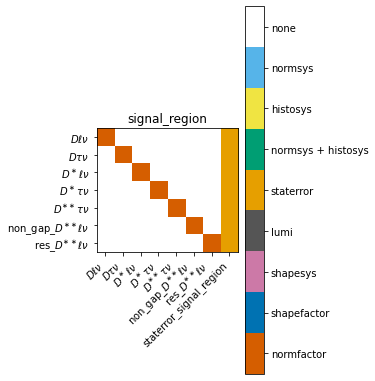

In [16]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

In [17]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier non_gap_$D^{\ast\ast}\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier res_$D^{\ast\ast}\ell\nu$ (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (749 new nuisance parameters)


In [3]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_prefit.pdf


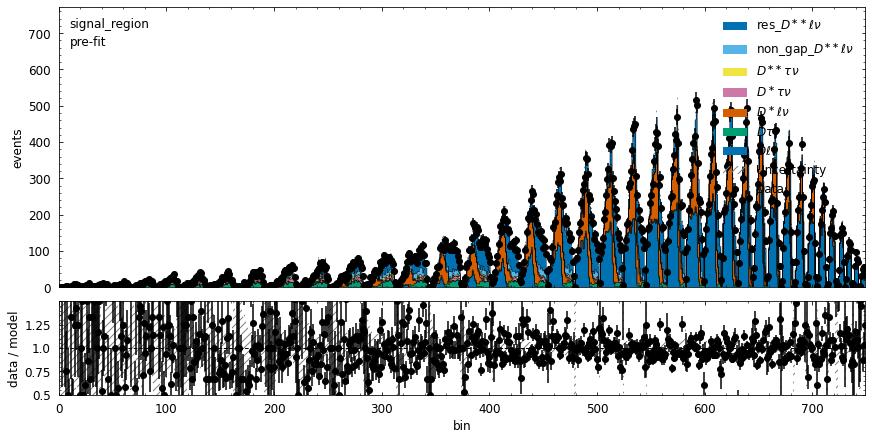

In [25]:
model_pred_prefit = cabinetry.model_utils.prediction(model)
#plt.figure(figsize=(16,6))
[dm] = cabinetry.visualize.data_mc(model_pred_prefit, data, log_scale=False)
dm['figure'].set_figwidth(12)

# 3. MLE

In [13]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3487                       │            Nfcn = 614259             │
│ EDM = 1.87e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - staterror_signal_region[89]   =  0.0000 +/- 9.3697
INFO - cabinetry.fit - staterror_signal_region[90]   =  0.0000 +/- 8.7060
INFO - cabinetry.fit - staterror_signal_region[91]   =  0.4915 +/- 0.3497
INFO - cabinetry.fit - staterror_signal_region[92]   =  0.0000 +/- 1.9542
INFO - cabinetry.fit - staterror_signal_region[93]   =  1.1119 +/- 0.4007
INFO - cabinetry.fit - staterror_signal_region[94]   =  1.0712 +/- 0.2676
INFO - cabinetry.fit - staterror_signal_region[95]   =  0.7661 +/- 0.2698
INFO - cabinetry.fit - staterror_signal_region[96]   =  1.1047 +/- 0.2362
INFO - cabinetry.fit - staterror_signal_region[97]   =  0.7158 +/- 0.2514
INFO - cabinetry.fit - staterror_signal_region[98]   =  1.4638 +/- 0.2511
INFO - cabinetry.fit - staterror_signal_region[99]   =  0.9755 +/- 0.1785
INFO - cabinetry.fit - staterror_signal_region[100]  =  1.2343 +/- 0.2253
INFO - cabinetry.fit - staterror_signal_region[101]  =  1.0840 +/- 0.1765
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[200]  =  1.0825 +/- 0.2887
INFO - cabinetry.fit - staterror_signal_region[201]  =  1.1969 +/- 0.2536
INFO - cabinetry.fit - staterror_signal_region[202]  =  1.2856 +/- 0.2138
INFO - cabinetry.fit - staterror_signal_region[203]  =  1.0452 +/- 0.1786
INFO - cabinetry.fit - staterror_signal_region[204]  =  0.9378 +/- 0.1835
INFO - cabinetry.fit - staterror_signal_region[205]  =  1.0332 +/- 0.1829
INFO - cabinetry.fit - staterror_signal_region[206]  =  1.0033 +/- 0.1393
INFO - cabinetry.fit - staterror_signal_region[207]  =  0.8911 +/- 0.1315
INFO - cabinetry.fit - staterror_signal_region[208]  =  0.9461 +/- 0.1229
INFO - cabinetry.fit - staterror_signal_region[209]  =  0.9625 +/- 0.1054
INFO - cabinetry.fit - staterror_signal_region[210]  =  1.0166 +/- 0.1054
INFO - cabinetry.fit - staterror_signal_region[211]  =  0.9588 +/- 0.1067
INFO - cabinetry.fit - staterror_signal_region[212]  =  0.8961 +/- 0.1008
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[311]  =  0.8694 +/- 0.0945
INFO - cabinetry.fit - staterror_signal_region[312]  =  1.2816 +/- 0.2358
INFO - cabinetry.fit - staterror_signal_region[313]  =  0.0000 +/- 9.3697
INFO - cabinetry.fit - staterror_signal_region[314]  =  1.2202 +/- 0.4973
INFO - cabinetry.fit - staterror_signal_region[315]  =  1.0739 +/- 0.2678
INFO - cabinetry.fit - staterror_signal_region[316]  =  0.8192 +/- 0.2361
INFO - cabinetry.fit - staterror_signal_region[317]  =  1.0264 +/- 0.1669
INFO - cabinetry.fit - staterror_signal_region[318]  =  1.1258 +/- 0.1667
INFO - cabinetry.fit - staterror_signal_region[319]  =  0.8898 +/- 0.1214
INFO - cabinetry.fit - staterror_signal_region[320]  =  1.1218 +/- 0.1273
INFO - cabinetry.fit - staterror_signal_region[321]  =  0.8342 +/- 0.1014
INFO - cabinetry.fit - staterror_signal_region[322]  =  0.8725 +/- 0.0850
INFO - cabinetry.fit - staterror_signal_region[323]  =  1.0374 +/- 0.0880
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[422]  =  0.9743 +/- 0.0623
INFO - cabinetry.fit - staterror_signal_region[423]  =  0.9265 +/- 0.0647
INFO - cabinetry.fit - staterror_signal_region[424]  =  1.0595 +/- 0.0663
INFO - cabinetry.fit - staterror_signal_region[425]  =  0.9680 +/- 0.0681
INFO - cabinetry.fit - staterror_signal_region[426]  =  0.9324 +/- 0.0711
INFO - cabinetry.fit - staterror_signal_region[427]  =  1.0526 +/- 0.0952
INFO - cabinetry.fit - staterror_signal_region[428]  =  0.9235 +/- 0.1508
INFO - cabinetry.fit - staterror_signal_region[429]  =  0.8258 +/- 0.1508
INFO - cabinetry.fit - staterror_signal_region[430]  =  1.1442 +/- 0.1313
INFO - cabinetry.fit - staterror_signal_region[431]  =  1.1199 +/- 0.1132
INFO - cabinetry.fit - staterror_signal_region[432]  =  0.9458 +/- 0.0801
INFO - cabinetry.fit - staterror_signal_region[433]  =  0.9375 +/- 0.0656
INFO - cabinetry.fit - staterror_signal_region[434]  =  1.1451 +/- 0.0660
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[533]  =  1.0192 +/- 0.0347
INFO - cabinetry.fit - staterror_signal_region[534]  =  1.0024 +/- 0.0338
INFO - cabinetry.fit - staterror_signal_region[535]  =  1.0174 +/- 0.0340
INFO - cabinetry.fit - staterror_signal_region[536]  =  0.9875 +/- 0.0401
INFO - cabinetry.fit - staterror_signal_region[537]  =  1.0123 +/- 0.0455
INFO - cabinetry.fit - staterror_signal_region[538]  =  0.9541 +/- 0.0465
INFO - cabinetry.fit - staterror_signal_region[539]  =  1.0031 +/- 0.0524
INFO - cabinetry.fit - staterror_signal_region[540]  =  1.0045 +/- 0.0565
INFO - cabinetry.fit - staterror_signal_region[541]  =  1.0137 +/- 0.0579
INFO - cabinetry.fit - staterror_signal_region[542]  =  1.0027 +/- 0.0629
INFO - cabinetry.fit - staterror_signal_region[543]  =  1.0538 +/- 0.0720
INFO - cabinetry.fit - staterror_signal_region[544]  =  0.8913 +/- 0.0923
INFO - cabinetry.fit - staterror_signal_region[545]  =  1.1460 +/- 0.3581
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[644]  =  1.0349 +/- 0.1362
INFO - cabinetry.fit - staterror_signal_region[645]  =  0.9652 +/- 0.0939
INFO - cabinetry.fit - staterror_signal_region[646]  =  1.1353 +/- 0.0663
INFO - cabinetry.fit - staterror_signal_region[647]  =  1.0669 +/- 0.0508
INFO - cabinetry.fit - staterror_signal_region[648]  =  0.9043 +/- 0.0432
INFO - cabinetry.fit - staterror_signal_region[649]  =  1.0015 +/- 0.0422
INFO - cabinetry.fit - staterror_signal_region[650]  =  1.0137 +/- 0.0372
INFO - cabinetry.fit - staterror_signal_region[651]  =  0.9322 +/- 0.0334
INFO - cabinetry.fit - staterror_signal_region[652]  =  0.9993 +/- 0.0329
INFO - cabinetry.fit - staterror_signal_region[653]  =  0.9909 +/- 0.0330
INFO - cabinetry.fit - staterror_signal_region[654]  =  1.0398 +/- 0.0416
INFO - cabinetry.fit - staterror_signal_region[655]  =  1.0788 +/- 0.0535
INFO - cabinetry.fit - staterror_signal_region[656]  =  1.0927 +/- 0.0687
INFO - cabinetry.fit - staterror_signa

CPU times: user 4min 43s, sys: 63.7 ms, total: 4min 43s
Wall time: 4min 43s


In [18]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])
# gap * 1.5

INFO - cabinetry.fit - performing maximum likelihood fit


W MnPosDef non-positive diagonal element in covariance matrix[ 25 ] = -0.0123233
W MnPosDef non-positive diagonal element in covariance matrix[ 54 ] = -0.0123233
W MnPosDef non-positive diagonal element in covariance matrix[ 76 ] = -0.0123233
W MnPosDef non-positive diagonal element in covariance matrix[ 119 ] = -0.0123237
W MnPosDef non-positive diagonal element in covariance matrix[ 486 ] = -0.0123478
W MnPosDef Added to diagonal of Error matrix a value 0.512349
W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3506                       │            Nfcn = 905235             │
│ EDM = 6.36e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3505.801742 at

INFO - cabinetry.fit - staterror_signal_region[90]   =  0.0000 +/- 7.6234
INFO - cabinetry.fit - staterror_signal_region[91]   =  0.4814 +/- 0.3461
INFO - cabinetry.fit - staterror_signal_region[92]   =  0.0000 +/- 1.6441
INFO - cabinetry.fit - staterror_signal_region[93]   =  1.0949 +/- 0.3975
INFO - cabinetry.fit - staterror_signal_region[94]   =  1.0565 +/- 0.2657
INFO - cabinetry.fit - staterror_signal_region[95]   =  0.7495 +/- 0.2669
INFO - cabinetry.fit - staterror_signal_region[96]   =  1.0916 +/- 0.2348
INFO - cabinetry.fit - staterror_signal_region[97]   =  0.7799 +/- 0.2482
INFO - cabinetry.fit - staterror_signal_region[98]   =  1.5166 +/- 0.2506
INFO - cabinetry.fit - staterror_signal_region[99]   =  0.9711 +/- 0.1767
INFO - cabinetry.fit - staterror_signal_region[100]  =  1.2507 +/- 0.2232
INFO - cabinetry.fit - staterror_signal_region[101]  =  1.0788 +/- 0.1750
INFO - cabinetry.fit - staterror_signal_region[102]  =  1.1067 +/- 0.1762
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[201]  =  1.1727 +/- 0.2511
INFO - cabinetry.fit - staterror_signal_region[202]  =  1.2874 +/- 0.2125
INFO - cabinetry.fit - staterror_signal_region[203]  =  1.0700 +/- 0.1770
INFO - cabinetry.fit - staterror_signal_region[204]  =  0.9386 +/- 0.1818
INFO - cabinetry.fit - staterror_signal_region[205]  =  1.0475 +/- 0.1814
INFO - cabinetry.fit - staterror_signal_region[206]  =  0.9895 +/- 0.1378
INFO - cabinetry.fit - staterror_signal_region[207]  =  0.9020 +/- 0.1302
INFO - cabinetry.fit - staterror_signal_region[208]  =  0.9456 +/- 0.1218
INFO - cabinetry.fit - staterror_signal_region[209]  =  0.9618 +/- 0.1045
INFO - cabinetry.fit - staterror_signal_region[210]  =  1.0271 +/- 0.1046
INFO - cabinetry.fit - staterror_signal_region[211]  =  0.9687 +/- 0.1057
INFO - cabinetry.fit - staterror_signal_region[212]  =  0.8929 +/- 0.1000
INFO - cabinetry.fit - staterror_signal_region[213]  =  1.0365 +/- 0.0974
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[312]  =  1.2820 +/- 0.2339
INFO - cabinetry.fit - staterror_signal_region[313]  =  0.0000 +/- 9.1212
INFO - cabinetry.fit - staterror_signal_region[314]  =  1.2229 +/- 0.4978
INFO - cabinetry.fit - staterror_signal_region[315]  =  1.0710 +/- 0.2675
INFO - cabinetry.fit - staterror_signal_region[316]  =  0.8176 +/- 0.2359
INFO - cabinetry.fit - staterror_signal_region[317]  =  1.0395 +/- 0.1668
INFO - cabinetry.fit - staterror_signal_region[318]  =  1.1285 +/- 0.1669
INFO - cabinetry.fit - staterror_signal_region[319]  =  0.8908 +/- 0.1215
INFO - cabinetry.fit - staterror_signal_region[320]  =  1.1203 +/- 0.1272
INFO - cabinetry.fit - staterror_signal_region[321]  =  0.8319 +/- 0.1013
INFO - cabinetry.fit - staterror_signal_region[322]  =  0.8691 +/- 0.0849
INFO - cabinetry.fit - staterror_signal_region[323]  =  1.0389 +/- 0.0879
INFO - cabinetry.fit - staterror_signal_region[324]  =  1.1581 +/- 0.0873
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[423]  =  0.9241 +/- 0.0641
INFO - cabinetry.fit - staterror_signal_region[424]  =  1.0629 +/- 0.0658
INFO - cabinetry.fit - staterror_signal_region[425]  =  0.9591 +/- 0.0675
INFO - cabinetry.fit - staterror_signal_region[426]  =  0.9292 +/- 0.0705
INFO - cabinetry.fit - staterror_signal_region[427]  =  1.0490 +/- 0.0944
INFO - cabinetry.fit - staterror_signal_region[428]  =  0.9059 +/- 0.1493
INFO - cabinetry.fit - staterror_signal_region[429]  =  0.8266 +/- 0.1508
INFO - cabinetry.fit - staterror_signal_region[430]  =  1.1452 +/- 0.1314
INFO - cabinetry.fit - staterror_signal_region[431]  =  1.1252 +/- 0.1132
INFO - cabinetry.fit - staterror_signal_region[432]  =  0.9462 +/- 0.0801
INFO - cabinetry.fit - staterror_signal_region[433]  =  0.9393 +/- 0.0656
INFO - cabinetry.fit - staterror_signal_region[434]  =  1.1469 +/- 0.0660
INFO - cabinetry.fit - staterror_signal_region[435]  =  1.0809 +/- 0.0554
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[534]  =  1.0025 +/- 0.0338
INFO - cabinetry.fit - staterror_signal_region[535]  =  1.0179 +/- 0.0340
INFO - cabinetry.fit - staterror_signal_region[536]  =  0.9838 +/- 0.0400
INFO - cabinetry.fit - staterror_signal_region[537]  =  1.0105 +/- 0.0453
INFO - cabinetry.fit - staterror_signal_region[538]  =  0.9517 +/- 0.0463
INFO - cabinetry.fit - staterror_signal_region[539]  =  1.0029 +/- 0.0521
INFO - cabinetry.fit - staterror_signal_region[540]  =  1.0044 +/- 0.0561
INFO - cabinetry.fit - staterror_signal_region[541]  =  1.0076 +/- 0.0575
INFO - cabinetry.fit - staterror_signal_region[542]  =  0.9972 +/- 0.0625
INFO - cabinetry.fit - staterror_signal_region[543]  =  1.0513 +/- 0.0715
INFO - cabinetry.fit - staterror_signal_region[544]  =  0.8848 +/- 0.0914
INFO - cabinetry.fit - staterror_signal_region[545]  =  1.1209 +/- 0.3543
INFO - cabinetry.fit - staterror_signal_region[546]  =  1.0271 +/- 0.0665
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[645]  =  0.9654 +/- 0.0939
INFO - cabinetry.fit - staterror_signal_region[646]  =  1.1356 +/- 0.0663
INFO - cabinetry.fit - staterror_signal_region[647]  =  1.0667 +/- 0.0508
INFO - cabinetry.fit - staterror_signal_region[648]  =  0.9037 +/- 0.0432
INFO - cabinetry.fit - staterror_signal_region[649]  =  1.0025 +/- 0.0422
INFO - cabinetry.fit - staterror_signal_region[650]  =  1.0147 +/- 0.0372
INFO - cabinetry.fit - staterror_signal_region[651]  =  0.9328 +/- 0.0334
INFO - cabinetry.fit - staterror_signal_region[652]  =  0.9996 +/- 0.0329
INFO - cabinetry.fit - staterror_signal_region[653]  =  0.9911 +/- 0.0330
INFO - cabinetry.fit - staterror_signal_region[654]  =  1.0383 +/- 0.0415
INFO - cabinetry.fit - staterror_signal_region[655]  =  1.0745 +/- 0.0533
INFO - cabinetry.fit - staterror_signal_region[656]  =  1.0877 +/- 0.0683
INFO - cabinetry.fit - staterror_signal_region[657]  =  0.9463 +/- 0.1326
INFO - cabinetry.fit - staterror_signa

CPU times: user 7min 1s, sys: 225 ms, total: 7min 2s
Wall time: 7min 3s


In [11]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])
# gap * 0.5

INFO - cabinetry.fit - performing maximum likelihood fit


W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def., try to make pos.def.
W MnPosDef Matrix forced pos-def by adding to diagonal 1.20461
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00304678 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid after second try
W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3473                       │            Nfcn = 617037             │
│ EDM = 2.3e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3472.692126 at

INFO - cabinetry.fit - staterror_signal_region[90]   =  0.0001 +/- 9.2774
INFO - cabinetry.fit - staterror_signal_region[91]   =  0.5016 +/- 0.3534
INFO - cabinetry.fit - staterror_signal_region[92]   =  0.0000 +/- 6.1979
INFO - cabinetry.fit - staterror_signal_region[93]   =  1.1294 +/- 0.4039
INFO - cabinetry.fit - staterror_signal_region[94]   =  1.0859 +/- 0.2694
INFO - cabinetry.fit - staterror_signal_region[95]   =  0.7825 +/- 0.2726
INFO - cabinetry.fit - staterror_signal_region[96]   =  1.1177 +/- 0.2376
INFO - cabinetry.fit - staterror_signal_region[97]   =  0.6409 +/- 0.2554
INFO - cabinetry.fit - staterror_signal_region[98]   =  1.4079 +/- 0.2517
INFO - cabinetry.fit - staterror_signal_region[99]   =  0.9794 +/- 0.1803
INFO - cabinetry.fit - staterror_signal_region[100]  =  1.2166 +/- 0.2275
INFO - cabinetry.fit - staterror_signal_region[101]  =  1.0890 +/- 0.1780
INFO - cabinetry.fit - staterror_signal_region[102]  =  1.0927 +/- 0.1794
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[201]  =  1.2207 +/- 0.2560
INFO - cabinetry.fit - staterror_signal_region[202]  =  1.2836 +/- 0.2151
INFO - cabinetry.fit - staterror_signal_region[203]  =  1.0184 +/- 0.1803
INFO - cabinetry.fit - staterror_signal_region[204]  =  0.9367 +/- 0.1851
INFO - cabinetry.fit - staterror_signal_region[205]  =  1.0179 +/- 0.1845
INFO - cabinetry.fit - staterror_signal_region[206]  =  1.0169 +/- 0.1408
INFO - cabinetry.fit - staterror_signal_region[207]  =  0.8794 +/- 0.1329
INFO - cabinetry.fit - staterror_signal_region[208]  =  0.9465 +/- 0.1240
INFO - cabinetry.fit - staterror_signal_region[209]  =  0.9630 +/- 0.1064
INFO - cabinetry.fit - staterror_signal_region[210]  =  1.0056 +/- 0.1062
INFO - cabinetry.fit - staterror_signal_region[211]  =  0.9482 +/- 0.1078
INFO - cabinetry.fit - staterror_signal_region[212]  =  0.8993 +/- 0.1016
INFO - cabinetry.fit - staterror_signal_region[213]  =  1.0340 +/- 0.0990
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[312]  =  1.2812 +/- 0.2378
INFO - cabinetry.fit - staterror_signal_region[313]  =  0.0134 +/- 9.3097
INFO - cabinetry.fit - staterror_signal_region[314]  =  1.2175 +/- 0.4967
INFO - cabinetry.fit - staterror_signal_region[315]  =  1.0766 +/- 0.2682
INFO - cabinetry.fit - staterror_signal_region[316]  =  0.8207 +/- 0.2363
INFO - cabinetry.fit - staterror_signal_region[317]  =  1.0131 +/- 0.1669
INFO - cabinetry.fit - staterror_signal_region[318]  =  1.1232 +/- 0.1665
INFO - cabinetry.fit - staterror_signal_region[319]  =  0.8888 +/- 0.1214
INFO - cabinetry.fit - staterror_signal_region[320]  =  1.1231 +/- 0.1273
INFO - cabinetry.fit - staterror_signal_region[321]  =  0.8365 +/- 0.1016
INFO - cabinetry.fit - staterror_signal_region[322]  =  0.8759 +/- 0.0852
INFO - cabinetry.fit - staterror_signal_region[323]  =  1.0358 +/- 0.0881
INFO - cabinetry.fit - staterror_signal_region[324]  =  1.1524 +/- 0.0876
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[423]  =  0.9290 +/- 0.0652
INFO - cabinetry.fit - staterror_signal_region[424]  =  1.0560 +/- 0.0667
INFO - cabinetry.fit - staterror_signal_region[425]  =  0.9772 +/- 0.0686
INFO - cabinetry.fit - staterror_signal_region[426]  =  0.9357 +/- 0.0717
INFO - cabinetry.fit - staterror_signal_region[427]  =  1.0563 +/- 0.0959
INFO - cabinetry.fit - staterror_signal_region[428]  =  0.9414 +/- 0.1522
INFO - cabinetry.fit - staterror_signal_region[429]  =  0.8250 +/- 0.1507
INFO - cabinetry.fit - staterror_signal_region[430]  =  1.1432 +/- 0.1312
INFO - cabinetry.fit - staterror_signal_region[431]  =  1.1147 +/- 0.1132
INFO - cabinetry.fit - staterror_signal_region[432]  =  0.9454 +/- 0.0801
INFO - cabinetry.fit - staterror_signal_region[433]  =  0.9357 +/- 0.0656
INFO - cabinetry.fit - staterror_signal_region[434]  =  1.1433 +/- 0.0660
INFO - cabinetry.fit - staterror_signal_region[435]  =  1.0811 +/- 0.0554
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[534]  =  1.0023 +/- 0.0338
INFO - cabinetry.fit - staterror_signal_region[535]  =  1.0168 +/- 0.0341
INFO - cabinetry.fit - staterror_signal_region[536]  =  0.9912 +/- 0.0402
INFO - cabinetry.fit - staterror_signal_region[537]  =  1.0142 +/- 0.0456
INFO - cabinetry.fit - staterror_signal_region[538]  =  0.9566 +/- 0.0467
INFO - cabinetry.fit - staterror_signal_region[539]  =  1.0033 +/- 0.0528
INFO - cabinetry.fit - staterror_signal_region[540]  =  1.0046 +/- 0.0569
INFO - cabinetry.fit - staterror_signal_region[541]  =  1.0198 +/- 0.0583
INFO - cabinetry.fit - staterror_signal_region[542]  =  1.0084 +/- 0.0634
INFO - cabinetry.fit - staterror_signal_region[543]  =  1.0564 +/- 0.0726
INFO - cabinetry.fit - staterror_signal_region[544]  =  0.8980 +/- 0.0931
INFO - cabinetry.fit - staterror_signal_region[545]  =  1.1709 +/- 0.3618
INFO - cabinetry.fit - staterror_signal_region[546]  =  1.0264 +/- 0.0665
INFO - cabinetry.fit - staterror_signa

INFO - cabinetry.fit - staterror_signal_region[645]  =  0.9651 +/- 0.0939
INFO - cabinetry.fit - staterror_signal_region[646]  =  1.1350 +/- 0.0663
INFO - cabinetry.fit - staterror_signal_region[647]  =  1.0671 +/- 0.0508
INFO - cabinetry.fit - staterror_signal_region[648]  =  0.9049 +/- 0.0432
INFO - cabinetry.fit - staterror_signal_region[649]  =  1.0005 +/- 0.0422
INFO - cabinetry.fit - staterror_signal_region[650]  =  1.0126 +/- 0.0372
INFO - cabinetry.fit - staterror_signal_region[651]  =  0.9315 +/- 0.0334
INFO - cabinetry.fit - staterror_signal_region[652]  =  0.9991 +/- 0.0329
INFO - cabinetry.fit - staterror_signal_region[653]  =  0.9908 +/- 0.0330
INFO - cabinetry.fit - staterror_signal_region[654]  =  1.0413 +/- 0.0417
INFO - cabinetry.fit - staterror_signal_region[655]  =  1.0831 +/- 0.0537
INFO - cabinetry.fit - staterror_signal_region[656]  =  1.0979 +/- 0.0692
INFO - cabinetry.fit - staterror_signal_region[657]  =  0.9369 +/- 0.1346
INFO - cabinetry.fit - staterror_signa

CPU times: user 4min 49s, sys: 112 ms, total: 4min 50s
Wall time: 4min 50s


In [ ]:
%%time
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=data, minos=model.config.parameters[:7])

In [ ]:
%%time
pyhf.set_backend('numpy','scipy')
parameters = pyhf.infer.mle.fit(data=data, pdf=model)
fit_results = cabinetry.fit.fit(model=model, data=data,init_pars=list(parameters),)
                                #minos=model.config.parameters[:7])

In [28]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

$D\ell\nu$: 0.983 +/- 0.026
$D\tau\nu$: 0.957 +/- 0.057
$D^\ast\ell\nu$: 1.063 +/- 0.056
$D^\ast\tau\nu$: 1.077 +/- 0.123
$D^{\ast\ast}\ell\nu$: 1.016 +/- 0.081
$D^{\ast\ast}\tau\nu$: 1.013 +/- 0.068
staterror_signal_region[0]: 0.000 +/- 8.524
staterror_signal_region[1]: 1.022 +/- 0.700
staterror_signal_region[2]: 0.993 +/- 0.690
staterror_signal_region[3]: 0.701 +/- 0.491
staterror_signal_region[4]: 2.022 +/- 0.703
staterror_signal_region[5]: 1.478 +/- 0.350
staterror_signal_region[6]: 0.503 +/- 0.205
staterror_signal_region[7]: 0.932 +/- 0.234
staterror_signal_region[8]: 0.696 +/- 0.247
staterror_signal_region[9]: 0.766 +/- 0.157
staterror_signal_region[10]: 0.802 +/- 0.147
staterror_signal_region[11]: 0.910 +/- 0.144
staterror_signal_region[12]: 0.827 +/- 0.139
staterror_signal_region[13]: 0.685 +/- 0.485
staterror_signal_region[14]: 0.685 +/- 0.346
staterror_signal_region[15]: 0.445 +/- 0.313
staterror_signal_region[16]: 1.283 +/- 0.405
staterror_signal_region[17]: 1.163 +/- 0.314


INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


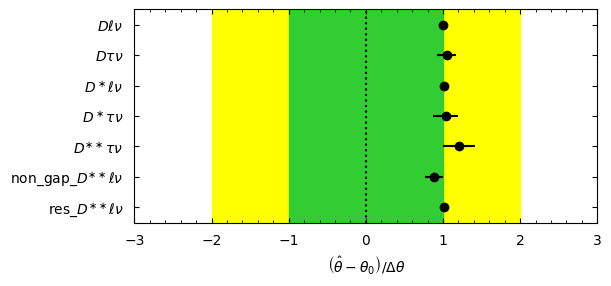

In [14]:
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


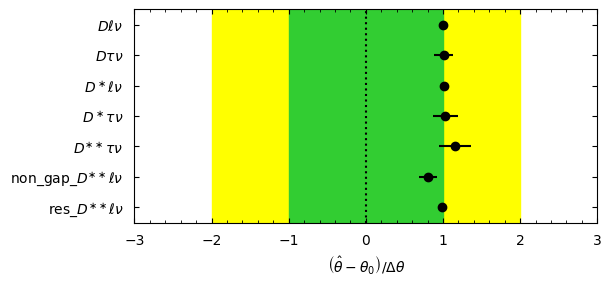

In [12]:
# gap * 0.5
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


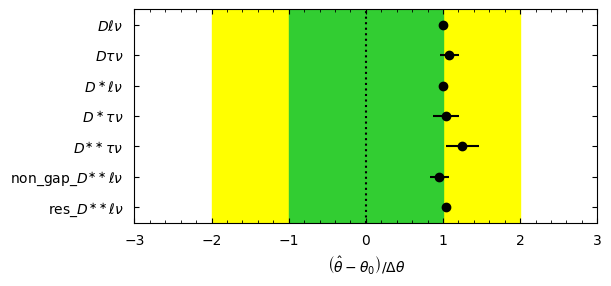

In [19]:
# gap * 1.5
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


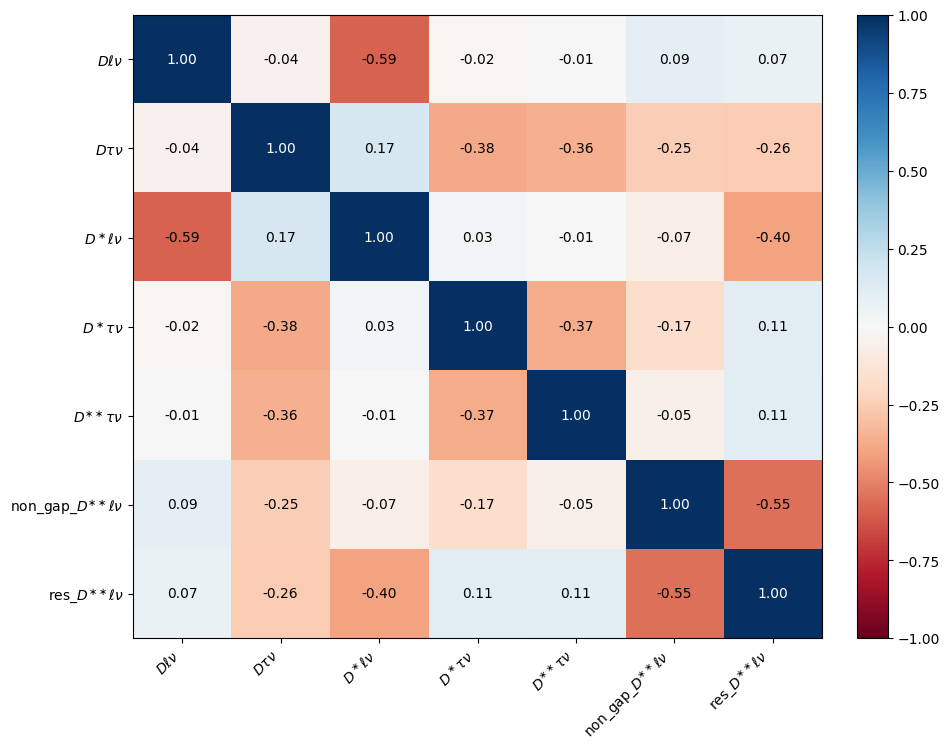

In [15]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.3)

In [31]:
# model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, log_scale=False)

TypeError: __init__() missing 1 required positional argument: 'dtype'

In [ ]:
templates = np.array([s['data'] for s in electron_channel['samples']])
counts=np.sum(test0,axis=0).reshape(41,47)

start = 0.8
end = 4.2
num_bins = 40
yedges = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -1.1
end = 8.6
num_bins = 50
xedges = np.linspace(start, end, num_bins + 1)

templates_2d = [t.reshape(counts.shape) for t in templates]
data_2d = counts

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,1.5],direction='p_D_l',plot_with='pltbar')

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,2.5],direction='mm2',plot_with='pltbar')

# 4. Asimov and Toys

In [ ]:
asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

In [5]:
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
poi = model.config.parameters[:6]

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
pyhf.set_backend("numpy", 'minuit')

# init the norm parameters
par_bounds = model.config.suggested_bounds()
fixed_params = model.config.suggested_fixed()
poi = model.config.parameters[:6] # same as model.config.par_order

In [5]:
from multiprocessing import Pool

def fit_toys(toy):
    try:
        return cabinetry.fit.fit(model=model, data=toy)
        # return pyhf.infer.mle.fit(toy, model,return_uncertainties=True)
    except pyhf.exceptions.FailedMinimization:
        pass

def generate_toys(init_norm=None, n_toys=100, poi=poi,seed=0):
    # initialize the generator and model
    toy_pars = model.config.suggested_init()
    rng = np.random.default_rng(seed)
    toy_pars[:len(poi)] = rng.random(len(poi))
    if type(init_norm) in [int, float]:
        toy_pars[:len(poi)] = [init_norm]*len(poi)
    # print(f"init parameters: {list(zip(model.config.parameters, [round(n,2) for n in toy_pars]))}")

    # make the pdfs
    pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(toy_pars))

    # draws samples from the pdf shape given the number of samples N=(10000,)
    return pdf_toy.sample((n_toys,)), toy_pars

def pull_plot(init_norm=None, n_toys=100, poi=poi):
    # create toys
    toys, toy_pars = generate_toys(init_norm=init_norm, n_toys=n_toys)
    
    # fit toys
    with Pool(None, maxtasksperchild=1) as p:
        fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))
    
    bestfit = np.array([f.bestfit for f in fit_results])
    errors = np.array([f.uncertainty for f in fit_results])
    
    # calculate pulls
    pulls = np.array(
        [
                (bestfit[:,model.config.par_slice(k)] - toy_pars[model.config.par_slice(k)])
                / errors[:,model.config.par_slice(k)]
            for k in model.config.par_order[:len(poi)]
        ]
    )
    
    # plot pulls
    bins = np.linspace(-5,5,50)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.hist(pulls[i], bins=bins)
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.axvline(0, label="expected", color="black", linestyle="dashed")
        ax.axvline(np.mean(pulls[i]), label="empirical mean", color="red", linestyle="dashed")
        ax.legend(title=f'$\sigma$ = {np.std(pulls[i]):.2f}')
        ax.grid()
               
    fig.suptitle(f'{len(fit_results)} successful toy fits pull plot',fontsize=16)
    fig.supylabel('# of toys per bin',x=0.06,fontsize=16)
    fig.supxlabel(r'Pulls = $(\mu - \hat{\mu})\,/ \delta \mu$', y=0.06,fontsize=16)
    
def linearity_plot(n_tests, n_toys, poi=poi):
    truth_all = np.empty((n_tests, len(poi)))
    fitted_all = np.empty((n_tests, len(poi)))
    errors_all = np.empty((n_tests, len(poi)))
    for i in range(n_tests):
        # initialize toys
        toys, toy_pars = generate_toys(n_toys=n_toys, seed=i)
        
        # fit toys
        with Pool(None, maxtasksperchild=10) as p:
            fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))

        bestfit = np.array([f.bestfit for f in fit_results])
        
        # save fitted parameters
        mean = np.mean(bestfit[:,:len(poi)], axis=1)
        std = np.std(bestfit[:,:len(poi)], axis=1)
        
        truth_all[i] = toy_pars[:len(poi)]
        fitted_all[i] = mean
        errors_all[i] = std
        
    # plot linearity
    bins = np.linspace(0,1,10)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.errorbar(x=truth_all[:,i], y=fitted_all[:,i], yerr=errors_all[:,i], fmt='ko')
        ax.plot(bins,bins,label="expected", color="red", linestyle="dashed")
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.legend()
        ax.grid()

    fig.suptitle(f'{n_tests} Test points with {n_toys} toys for each point',fontsize=16)
    fig.supylabel('Fitted',x=0.06,fontsize=16)
    fig.supxlabel('Truth', y=0.06,fontsize=16)

In [9]:
a=[1,2,3]
def square(x):
    return x**2
if __name__ == '__main__':
    with Pool(None, maxtasksperchild=1) as p:
        r = np.array(list(tqdm(p.imap(square, a), total=len(a),desc =f"Fitting toys")))
    print(r)

Fitting toys:   0%|          | 0/3 [00:00<?, ?it/s]

[1 4 9]


In [ ]:
pull_plot(init_norm=1, n_toys=50)

Fitting toys:   0%|          | 0/50 [00:00<?, ?it/s]

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.168366 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.000859329
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.00199864
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.0115167
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -0.033026
W MnPosDef non-positive diagonal element in covariance matrix[ 4 ] = -0.0137391
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -0.00364929
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -0.0537739
W MnPosDef non-positive diagonal element in covariance matrix[ 9 ] = -0.0211273
W MnPosDef non-positive diagonal element in covariance matrix[ 17 ] = -0.000115004
W MnPosDef non-positive diagonal element in covariance matrix[ 55 ] = -0.0209275
W MnPosDef non-positive diagonal element in cov

Process ForkPoolWorker-72:
Process ForkPoolWorker-67:
Process ForkPoolWorker-71:
Process ForkPoolWorker-76:
Process ForkPoolWorker-79:
Process ForkPoolWorker-78:
Process ForkPoolWorker-51:
Process ForkPoolWorker-65:
Process ForkPoolWorker-68:
Process ForkPoolWorker-66:
Process ForkPoolWorker-70:
Process ForkPoolWorker-64:
Process ForkPoolWorker-69:
Process ForkPoolWorker-77:
Process ForkPoolWorker-75:
Process ForkPoolWorker-80:
Process ForkPoolWorker-62:
Process ForkPoolWorker-55:
Process ForkPoolWorker-58:
Process ForkPoolWorker-73:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-63:
Process ForkPoolWorker-60:
Process ForkPoolWorker-57:
Process ForkPoolWorker-59:
Process ForkPoolWorker-52:
Process ForkPoolWorker-54:
Process ForkPoolWorker-74:
Process ForkPoolWorker-61:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*se

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/m

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    r

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/ext

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 1

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
Traceback (most recent call last):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/li

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 115, in _minimize
    minimizer.migrad(ncall=maxiter)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/e

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 702, in migrad
    fm = migrad(ncall, self._tolerance)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/o

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zh

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 19

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-pac

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 945, in logpdf
    result = self.make_pdf(pars).log_prob(data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, 

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in log_prob
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 186, in log_prob
    result = super().log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-package

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 254, in sum
    return np.sum(tensor_in, axis=axis)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/modifiers/normfactor.py", line 113, in apply
    results_normfactor = tensorlib.where(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in <listcomp>
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3076, in prod
    return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 355, in where
    return np.where(mask, tensor_in_1, tensor_in_2)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "<__array_function__ internals>", line 200, in where
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 2324, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 439, in poisson_

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 490, in normal_logpdf
    root2pi = np.sqrt(2 * np.pi)
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 70, in <dictcomp>
    passkwargs = {k: v for k, v in kwargs.items()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 436, in einsum
    return np.einsum(subscripts, *operands)  # type: ignore[arg-type,no-any-return]
  File "<__array_function__ internals>", line 200, in prod
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 50, in log_prob
    return tensorlib.normal_logpdf(value, self.loc, self.scale)
  File "<__array_function__ internals>", line 200, in einsum
KeyboardInterrupt
  File "<__array_function__ internals>", line 200, in einsum
  File "<__array_function__ internals>", line 200, in where
KeyboardInterrupt
  File

In [7]:
linearity_plot(n_tests=40, n_toys=50, poi=poi)

Process ForkPoolWorker-75:
Process ForkPoolWorker-70:
Process ForkPoolWorker-80:
Process ForkPoolWorker-65:
Process ForkPoolWorker-73:
Process ForkPoolWorker-67:
Process ForkPoolWorker-72:
Process ForkPoolWorker-76:
Process ForkPoolWorker-63:
Process ForkPoolWorker-79:
Process ForkPoolWorker-61:
Process ForkPoolWorker-77:
Process ForkPoolWorker-55:
Process ForkPoolWorker-68:
Process ForkPoolWorker-57:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-69:
Process ForkPoolWorker-58:
Process ForkPoolWorker-78:
Process ForkPoolWorker-64:
Process ForkPoolWorker-74:
Process ForkPoolWorker-66:
Process ForkPoolWorker-60:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-62:
Process ForkPoolWorker-71:
Process ForkPoolWorker-59:
Process ForkPoolWorker-51:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pr

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/sy

KeyboardInterrupt: 